# Import

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# !pip install pyensembl
from pyensembl import EnsemblRelease
from scipy.stats import poisson

# Load Files

In [2]:
# Load File
DATA_PATH = Path('../../Data/')
metadata = pd.read_csv(Path(DATA_PATH, 'Original/TCGA.HNSC.metadata.txt'), sep = '\t').fillna("NaN")
mutations = pd.read_csv(Path(DATA_PATH, 'Original/TCGA.HNSC.mutations.txt'), sep = '\t').fillna("NaN")

# Functions

In [3]:
codon_to_aa = {
    'TTT': 'F', 'TTC': 'F', 'TTA': 'L', 'TTG': 'L',
    'CTT': 'L', 'CTC': 'L', 'CTA': 'L', 'CTG': 'L',
    'ATT': 'I', 'ATC': 'I', 'ATA': 'I', 'ATG': 'M',
    'GTT': 'V', 'GTC': 'V', 'GTA': 'V', 'GTG': 'V',
    'TCT': 'S', 'TCC': 'S', 'TCA': 'S', 'TCG': 'S',
    'CCT': 'P', 'CCC': 'P', 'CCA': 'P', 'CCG': 'P',
    'ACT': 'T', 'ACC': 'T', 'ACA': 'T', 'ACG': 'T',
    'GCT': 'A', 'GCC': 'A', 'GCA': 'A', 'GCG': 'A',
    'TAT': 'Y', 'TAC': 'Y', 'TAA': '*', 'TAG': '*',
    'CAT': 'H', 'CAC': 'H', 'CAA': 'Q', 'CAG': 'Q',
    'AAT': 'N', 'AAC': 'N', 'AAA': 'K', 'AAG': 'K',
    'GAT': 'D', 'GAC': 'D', 'GAA': 'E', 'GAG': 'E',
    'TGT': 'C', 'TGC': 'C', 'TGA': '*', 'TGG': 'W',
    'CGT': 'R', 'CGC': 'R', 'CGA': 'R', 'CGG': 'R',
    'AGT': 'S', 'AGC': 'S', 'AGA': 'R', 'AGG': 'R',
    'GGT': 'G', 'GGC': 'G', 'GGA': 'G', 'GGG': 'G'
}

In [4]:
def classify_dn_ds(vclass):
    if vclass == 'Silent':
        return 'synonymous'
    else:
        return 'nonsynonymous'

In [5]:
def get_substitution(ref, alt):
    valid_bases = {'A', 'C', 'G', 'T'}
    if ref not in valid_bases or alt not in valid_bases:
        return None

    if ref in ['C', 'T']:
        return ref + "->" + alt
    else:
        # Reverse complement both ref and alt
        complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}
        norm_ref = complement[ref]
        norm_alt = complement[alt]
        return norm_ref + "->" + norm_alt

In [6]:
def dn_ds_ratio(subset):
    n_dN = (subset['_dn_ds_mutation_type'] == 'nonsynonymous').sum()
    n_dS = (subset['_dn_ds_mutation_type'] == 'synonymous').sum()
    if n_dS == 0:
        ratio = (n_dN + 1) / (n_dS + 1)  # add pseudocount
    else:
        ratio = n_dN/n_dS
    return ratio 

In [7]:
def simulate_gene_mutations(cds_seq, mutation_rate_dict, codon_to_aa):
    results = []
    codons = [cds_seq[i:i+3] for i in range(0, len(cds_seq), 3)]

    for codon_idx, codon in enumerate(codons):
        if len(codon) < 3 or codon not in codon_to_aa:
            continue  # skip incomplete or invalid codons

        for pos in range(3):  # position within codon
            ref_base = codon[pos]

            for alt_base in ['A', 'C', 'G', 'T']:
                if alt_base == ref_base:
                    continue

                # Mutate codon
                mutated = list(codon)
                mutated[pos] = alt_base
                mutated_codon = ''.join(mutated)

                if mutated_codon not in codon_to_aa:
                    continue  # skip invalid codons

                # Determine mutation type
                original_aa = codon_to_aa[codon]
                mutated_aa = codon_to_aa[mutated_codon]
                mutation_type = 'synonymous' if original_aa == mutated_aa else 'nonsynonymous'

                # Get center position in CDS
                genome_pos = codon_idx * 3 + pos
                if genome_pos < 1 or genome_pos >= len(cds_seq) - 1:
                    continue  # skip edges

                # Get trinucleotide context (5' and 3' bases)
                context = cds_seq[genome_pos - 1] + "_" + cds_seq[genome_pos + 1]
                substitution = get_substitution(ref_base, alt_base)

                # Get mutation rate
                mutation_prob = mutation_rate_dict.get((context, substitution), 0.0)

                results.append({
                    'codon_index': codon_idx,
                    'codon': codon,
                    'mutated_codon': mutated_codon,
                    'ref_base': ref_base,
                    'alt_base': alt_base,
                    'position_in_codon': pos,
                    'context': context,
                    'substitution': substitution,
                    'mutation_type': mutation_type,
                    'mutation_probability': mutation_prob
                })

    return results

# Preprocessing
modified from Harrison's code

In [8]:
# 1. filter to pass: kept high-quality mutations
mutations = mutations[mutations['FILTER'] == 'PASS']

# 2. remove deprecated vairant callers and missing callers
# from mutations['CALLERS'], remove str matching 'RADIA' and 'SOMATICSNIPER'
mutations['CALLERS'] = mutations['CALLERS'].replace(to_replace='*', value='')
mutations['CALLERS'] = mutations['CALLERS'].replace(to_replace='RADIA', value='')
mutations['CALLERS'] = mutations['CALLERS'].replace(to_replace='SOMATICSNIPER', value='')
# in mutations['CALLERS'], if 2 '|' are next to each other, replace with ''
mutations['CALLERS'] = mutations['CALLERS'].replace(to_replace='\\|\\|', value='', regex=True)
# count the number of '|' in mutations['CALLERS'] and store in a new column 'CALLERS_COUNT_ADJUSTED'
mutations['CALLERS_COUNT_ADJUSTED'] = mutations['CALLERS'].str.count('\\|')

# 3. Filter to consensus mutations
mutations = mutations[mutations['CALLERS_COUNT_ADJUSTED'] > 1]

# 4. Filter by n_depth >=10
mutations = mutations[mutations['n_depth'] >= 10] 

# 5. Filter by hypermutators > 1000 mutations per patient
# Identify patients with >1000 mutations
hypermutators = mutations['patient_id'].value_counts()
hypermutators = hypermutators[hypermutators > 1000].index
# Remove those patients
mutations = mutations[~mutations['patient_id'].isin(hypermutators)]


In [9]:
# !!!!! additional step !!!!!
# 6. Only SNP mutations should be analyzed
mutations = mutations[mutations['Variant_Type'] == 'SNP']

# 7. additional column on mutation type and trinucleotide contextx
# dn/ds mutation
mutations.loc[:, '_dn_ds_mutation_type'] = mutations['Variant_Classification'].apply(classify_dn_ds)
# trinucleotide
mutations.loc[:, '_trinucleotide'] = mutations['CONTEXT'].str.slice(4, 7)
# 16 type context
mutations['_16_type_context'] = mutations['CONTEXT'].str[4] + '_' + mutations['CONTEXT'].str[6]
# 6 substitution 
# mutations['_substitution'] = mutations.apply(
#     lambda row: get_substitution(row['Reference_Allele'], row['Tumor_Seq_Allele2']), axis=1
# )
mutations['_substitution'] = mutations['Reference_Allele'] + "->" + mutations['Tumor_Seq_Allele2']
mutations['_96_class'] = mutations['_16_type_context'] + '__' + mutations['_substitution']

# Overview

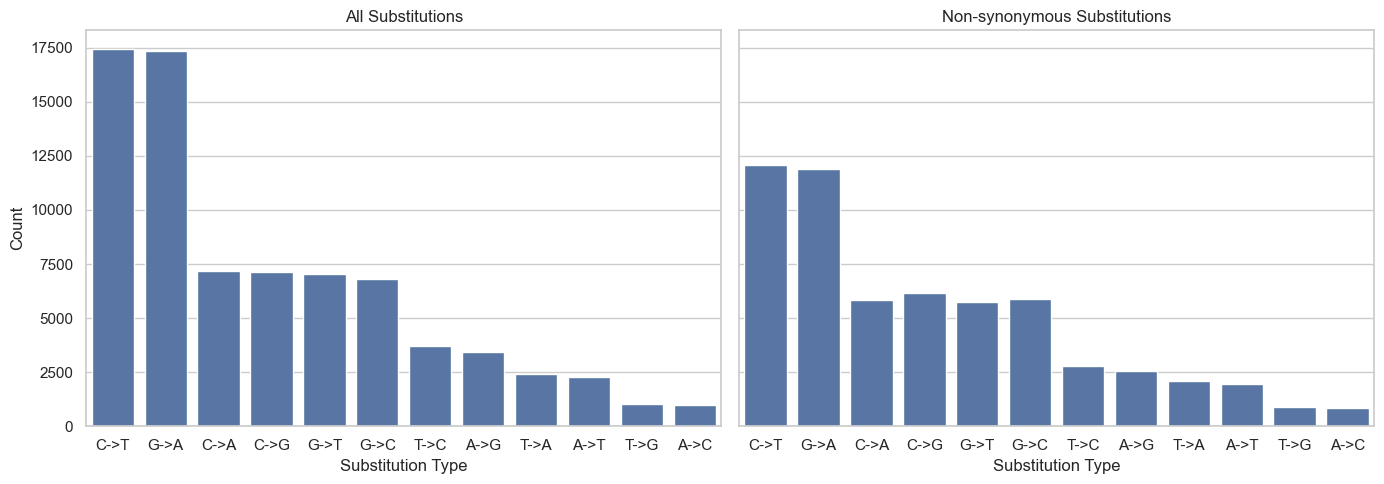

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Plot 1: All substitutions
sns.countplot(ax=axes[0], x='_substitution', data=mutations,
              order=mutations['_substitution'].value_counts().index)
axes[0].set_title("All Substitutions")
axes[0].set_xlabel("Substitution Type")
axes[0].set_ylabel("Count")

# Plot 2: Non-synonymous substitutions
nonsyn = mutations[mutations['_dn_ds_mutation_type'] == 'nonsynonymous']
sns.countplot(ax=axes[1], x='_substitution', data=nonsyn,
              order=mutations['_substitution'].value_counts().index)
axes[1].set_title("Non-synonymous Substitutions")
axes[1].set_xlabel("Substitution Type")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()


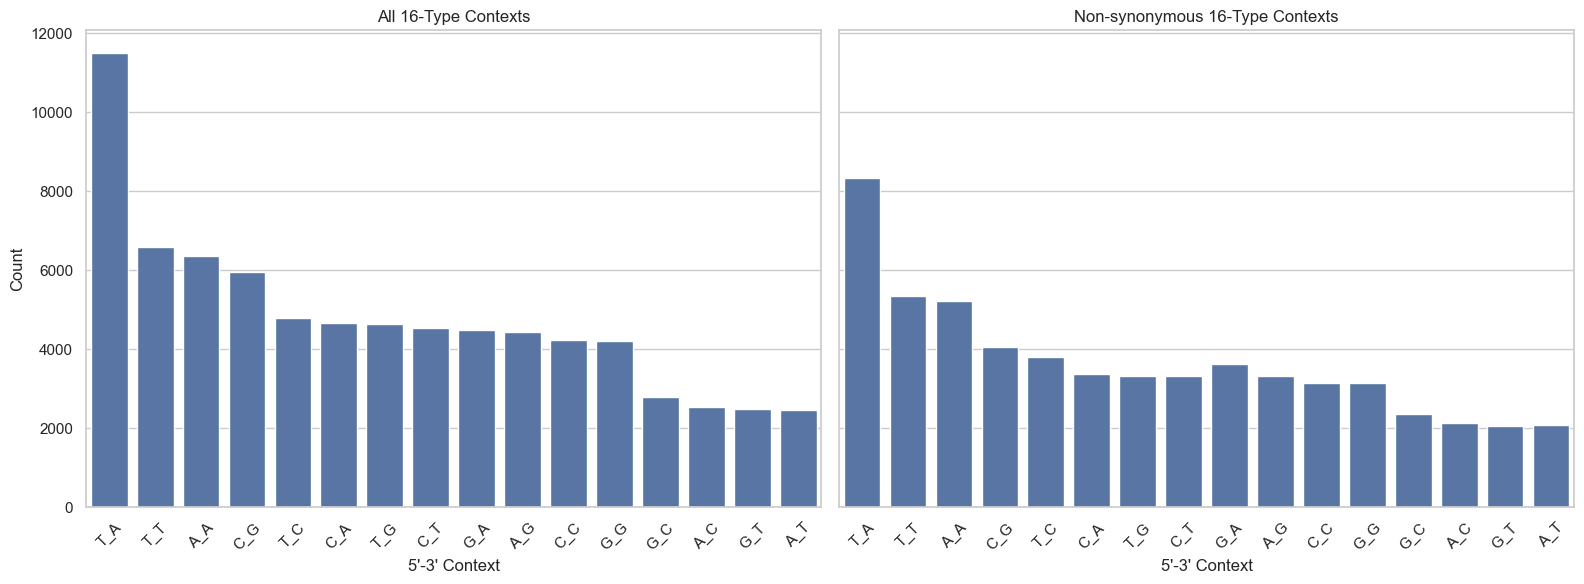

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot 1: All 16-type contexts
sns.countplot(ax=axes[0], x='_16_type_context', data=mutations,
              order=mutations['_16_type_context'].value_counts().index)
axes[0].set_title("All 16-Type Contexts")
axes[0].set_xlabel("5'-3' Context")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Non-synonymous mutations only
nonsyn = mutations[mutations['_dn_ds_mutation_type'] == 'nonsynonymous']
sns.countplot(ax=axes[1], x='_16_type_context', data=nonsyn,
              order=mutations['_16_type_context'].value_counts().index)
axes[1].set_title("Non-synonymous 16-Type Contexts")
axes[1].set_xlabel("5'-3' Context")
axes[1].set_ylabel("")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# Trinucleotide dn/ds

In [32]:
# 1. background model/probability 

# Count how many times each 96-class mutation occurs
count_df = mutations['_96_class'].value_counts().reset_index()
count_df.columns = ['_96_class', 'count']

# Split the _96_class into context and substitution
count_df[['_16_type_context', '_substitution']] = count_df['_96_class'].str.split('__', expand=True)

# Group by context and substitution, then sum counts
grouped = count_df.groupby(['_16_type_context', '_substitution'])['count'].sum().reset_index()

# Normalize within each context group to get mutation probabilities
grouped['mutation_rate'] = grouped.groupby('_16_type_context')['count'].transform(lambda x: x / x.sum())

# switch to dictionary 
mutation_rate_dict = {
    (row['_16_type_context'], row['_substitution']): row['mutation_rate']
    for _, row in grouped.iterrows()
}

In [89]:
genes = list(set(mutations.Hugo_Symbol.tolist()))
patients = list(set(mutations.patient_id.tolist()))
observed = []
expected = []

# testing
for gene in genes:
    # 2.1 Observed dN_dS
    mutation_per_gene = mutations[mutations.Hugo_Symbol == gene].copy()
    observed_dN_dS = dn_ds_ratio(mutation_per_gene)
    observed.append(observed_dN_dS)
    
    # 2.2 Expected dN_dS
    
    # i) get coding sequence and codon structure
    # Use Ensembl v75 (for GRCh37 / hg19)
    # data = EnsemblRelease(75)
    # data.download()
    # data.index()
    transcript_ids = data.transcript_ids_of_gene_name(gene)
    
    cds_seq = None
    for tid in transcript_ids:
        try:
            transcript = data.transcript_by_id(tid)
            cds_seq = transcript.coding_sequence
            break
        except ValueError:
            continue
    
    if cds_seq is None:
        #print(f"{gene}: No valid coding transcript found.")
        expected.append(float('nan'))
        continue
    
    # ii) simulate all possible point mutations 
    gene_results = pd.DataFrame(simulate_gene_mutations(cds_seq, mutation_rate_dict, codon_to_aa))
    
    # iii) calculate expected dN_dS
    nonsyn_sum = gene_results[gene_results['mutation_type'] == 'nonsynonymous']['mutation_probability'].sum()
    syn_sum = gene_results[gene_results['mutation_type'] == 'synonymous']['mutation_probability'].sum()
    
    expected_dN_dS = nonsyn_sum / syn_sum if syn_sum != 0 else float('inf')
    expected.append(expected_dN_dS)


In [90]:
dnds_df = pd.DataFrame({
    'gene': genes,
    'observed_dNdS': observed,
    'expected_dNdS': expected
}).set_index('gene')

In [67]:
#dnds_df.to_csv("gene_dnds_trinucleotide_context_summary.csv")

In [91]:
dnds_df['ratio'] = dnds_df.observed_dNdS/dnds_df.expected_dNdS

In [113]:
dnds_df.sort_values(by='ratio',ascending=False).head(60)

observed_dNdS  expected_dNdS      ratio
gene                                             
CDKN2A        82.000000       2.503875  32.749232
PIK3CA        82.000000       3.544052  23.137358
KMT2D         52.000000       2.548086  20.407475
CASP8         49.000000       2.513428  19.495288
HRAS          35.000000       2.009902  17.413781
NSD1          48.000000       3.312729  14.489564
EP300         34.000000       3.408903   9.973883
KEAP1         20.000000       2.070591   9.659077
TP53          24.307692       2.644753   9.190913
TGFBR2        19.000000       2.431584   7.813836
NFE2L2        25.000000       3.406374   7.339183
PDE10A        21.000000       2.983306   7.039171
DLG2          20.000000       2.916445   6.857663
HLA-B         15.000000       2.190457   6.847885
LTBP1         20.000000       2.921945   6.844757
AJUBA         16.000000       2.415088   6.625018
NPFFR2        18.000000       2.734619   6.582271
HERC1         21.000000       3.194906   6.572963
DGKK          19.000000       2.989002   6.356636
PSG8          16.000000       2.632583   6.077680
PCDHB13       12.000000       1.996391   6.010847
NLRP2         13.000000       2.169406   5.992423
SPTBN1        14.000000       2.359336   5.933872
JMJD1C        22.000000       3.772518   5.831648
PTGER3        12.000000       2.066354   5.807331
LAMB4         18.000000       3.125189   5.759651
FREM1         15.000000       2.676921   5.603453
CASZ1         12.000000       2.141866   5.602592
FGFR3         11.000000       1.975803   5.567357
ATP8A2        14.000000       2.516926   5.562341
DOPEY1        18.000000       3.299296   5.455709
ZNF646        14.000000       2.581001   5.424253
TMEM132E      10.000000       1.847968   5.411348
TMEM132B      13.000000       2.424630   5.361643
RARG          12.000000       2.253783   5.324382
TMEM2         16.000000       3.025682   5.288064
BIRC6         18.000000       3.403930   5.288006
NLRP14        15.000000       2.842494   5.277056
REG1A         14.000000       2.706275   5.173162
NOTCH1        11.166667       2.172243   5.140616
SULF1         15.000000       2.919133   5.138511
SBF1          10.000000       1.953351   5.119407
ZNF750        13.000000       2.541616   5.114856
SEL1L2        16.000000       3.133016   5.106901
ROBO2         16.000000       3.166348   5.053141
DIP2C         11.000000       2.201298   4.997051
MYOM1         14.000000       2.808444   4.984966
WNK4          12.000000       2.416626   4.965600
ACACA         14.000000       2.839010   4.931296
AHDC1         11.000000       2.234106   4.923670
SLC38A10      10.000000       2.058391   4.858164
SLC13A3       10.000000       2.060998   4.852018
OR2M5         13.000000       2.680021   4.850708
DNHD1         11.000000       2.272441   4.840610
KIF6          13.000000       2.688965   4.834573
RPGRIP1       13.000000       2.697733   4.818861
PAPPA         12.000000       2.491055   4.817236
SHANK1        10.000000       2.084796   4.796632
SMARCA4       10.500000       2.197259   4.778682
CDH12         14.000000       2.930075   4.778035

# Statistical Testing 

In [25]:
#df = dnds_df.copy()
df = pd.read_csv("gene_dnds_trinucleotide_context_summary.csv")
ALPHA = 0.05

In [26]:
def poisson_p_two_sided(obs, exp):
    """Exact two-sided Poisson p-value."""
    if pd.isna(obs) or pd.isna(exp) or exp <= 0:
        return np.nan
    if obs >= exp:
        p = poisson.sf(obs - 1, exp) * 2.0     # right tail *2
    else:
        p = poisson.cdf(obs, exp) * 2.0        # left tail *2
    return min(p, 1.0)

In [27]:
df["p_value"] = [
    poisson_p_two_sided(o, e)
    for o, e in zip(df["observed_dNdS"], df["expected_dNdS"])
]

# ---------------------- 3. Bonferroni adjustment -----------------------
pvals = pd.to_numeric(df["p_value"], errors="coerce")
valid_mask = pvals.notna()
m = valid_mask.sum()          # number of valid tests

if m == 0:
    raise ValueError("No valid p-values to adjust.")

try:
    from statsmodels.stats.multitest import multipletests
    reject, p_bonf, _, _ = multipletests(
        pvals[valid_mask], alpha=ALPHA, method="bonferroni"
    )
    df.loc[valid_mask, "p_bonf"]     = p_bonf
    df.loc[valid_mask, "signif_bonf"] = reject
except ModuleNotFoundError:
    # Manual Bonferroni: p_adj = p_raw * m
    p_bonf = np.minimum(pvals[valid_mask] * m, 1.0)
    df.loc[valid_mask, "p_bonf"]     = p_bonf
    df.loc[valid_mask, "signif_bonf"] = p_bonf < ALPHA

# ---------------------- 5. Select & rank significant -------------------
sig_df = (
    df[df["p_bonf"] < ALPHA]
      .sort_values("p_bonf")
      .reset_index(drop=True)
)

In [47]:
sig_df

gene  observed_dNdS  expected_dNdS       p_value        p_bonf  \
0    CDKN2A      82.000000       2.554473  8.450562e-91  1.352682e-86   
1    PIK3CA      82.000000       3.708402  5.088832e-78  8.145693e-74   
2     KMT2D      52.000000       2.653734  2.017221e-47  3.228966e-43   
3     CASP8      49.000000       2.679574  2.250706e-43  3.602706e-39   
4      NSD1      48.000000       3.319207  6.392512e-38  1.023249e-33   
5      HRAS      35.000000       2.082437  3.616247e-30  5.788526e-26   
6     EP300      34.000000       3.403238  3.030277e-22  4.850564e-18   
7      TP53      24.307692       2.680771  4.691784e-15  7.510139e-11   
8    NFE2L2      25.000000       3.517361  1.999770e-13  3.201031e-09   
9     KEAP1      20.000000       2.192467  6.745532e-13  1.079757e-08   
10   PDE10A      21.000000       3.059148  3.359468e-11  5.377501e-07   
11   TGFBR2      19.000000       2.485469  5.087382e-11  8.143372e-07   
12    LTBP1      20.000000       2.936043  1.148014e-10  1.837627e-06   
13    HERC1      21.000000       3.313283  1.410879e-10  2.258394e-06   
14     DLG2      20.000000       3.049543  2.201879e-10  3.524548e-06   
15   JMJD1C      22.000000       3.864473  3.690673e-10  5.907660e-06   
16     DGKK      19.000000       3.091217  1.811959e-09  2.900403e-05   
17   NPFFR2      18.000000       2.887848  3.997398e-09  6.398635e-05   
18    AJUBA      16.000000       2.421546  1.381423e-08  2.211244e-04   
19    LAMB4      18.000000       3.171947  1.657619e-08  2.653350e-04   
20    HLA-B      15.000000       2.297985  4.713895e-08  7.545532e-04   
21     PSG8      16.000000       2.671584  5.271143e-08  8.437518e-04   
22   DOPEY1      18.000000       3.444142  5.652225e-08  9.047517e-04   
23    BIRC6      18.000000       3.507237  7.386701e-08  1.182389e-03   
24    TMEM2      16.000000       3.120951  4.173690e-07  6.680825e-03   
25    FREM1      15.000000       2.818196  6.211632e-07  9.942960e-03   
26   SEL1L2      16.000000       3.263412  7.467215e-07  1.195277e-02   
27    ROBO2      16.000000       3.268356  7.615212e-07  1.218967e-02   
28   SPTBN1      14.000000       2.552626  1.070979e-06  1.714315e-02   
29    SULF1      15.000000       2.994301  1.309962e-06  2.096856e-02   
30   ATP8A2      14.000000       2.623334  1.470967e-06  2.354577e-02   
31   NLRP14      15.000000       3.035251  1.546285e-06  2.475138e-02   
32    REG1A      14.000000       2.644261  1.612645e-06  2.581360e-02   
33   ZNF646      14.000000       2.652284  1.670121e-06  2.673363e-02   
34      APC      17.000000       3.955805  1.954523e-06  3.128605e-02   
35     HFM1      17.000000       3.991971  2.206007e-06  3.531156e-02   
36  ANKRD17      16.000000       3.556282  2.250177e-06  3.601859e-02   
37    NLRP2      13.000000       2.358552  2.545833e-06  4.075115e-02   

   signif_bonf  
0         True  
1         True  
2         True  
3         True  
4         True  
5         True  
6         True  
7         True  
8         True  
9         True  
10        True  
11        True  
12        True  
13        True  
14        True  
15        True  
16        True  
17        True  
18        True  
19        True  
20        True  
21        True  
22        True  
23        True  
24        True  
25        True  
26        True  
27        True  
28        True  
29        True  
30        True  
31        True  
32        True  
33        True  
34        True  
35        True  
36        True  
37        True

In [ ]:
# # ---------------------- 4. Save full result table ----------------------
# df.to_csv(FULL_OUTPUT, index=False)
# print(f"Full results written to {FULL_OUTPUT}")
# sig_df.to_csv(SIG_OUTPUT, index=False)
# print(f"{len(sig_df)} significant genes (Bonferroni, α={ALPHA}) "
#       f"written to {SIG_OUTPUT}")

In [24]:
df[df['expected_dNdS'].isna()].sort_values(by = "observed_dNdS")

gene  observed_dNdS  expected_dNdS  p_value  p_bonf signif_bonf
10241       TRBV7-7            0.0            NaN      NaN     NaN         NaN
772    RP11-468E2.6            0.0            NaN      NaN     NaN         NaN
8263          TRBV9            0.0            NaN      NaN     NaN         NaN
8171          TRAV7            0.0            NaN      NaN     NaN         NaN
8745       IGHD5-12            0.0            NaN      NaN     NaN         NaN
...             ...            ...            ...      ...     ...         ...
7237        HERC2P3           18.0            NaN      NaN     NaN         NaN
12260    SPATA31D5P           23.0            NaN      NaN     NaN         NaN
15004          SSPO           24.0            NaN      NaN     NaN         NaN
11407          XIST           30.0            NaN      NaN     NaN         NaN
4083         MALAT1           41.0            NaN      NaN     NaN         NaN

[649 rows x 6 columns]